## EE5175 -Image Signal Processing

#### Lab-3

## Image mosaicing

###### importing libraries

In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import os 
import sys 
import random
import math as m
from skimage.io import imread 
from sift import * #giving error on featured2d so had to go for the function from the gfg

In [2]:
img1 = imread('./img1.png')
img2 = imread('./img2.png')
img3 = imread('./img3.png')

###### plotting given images

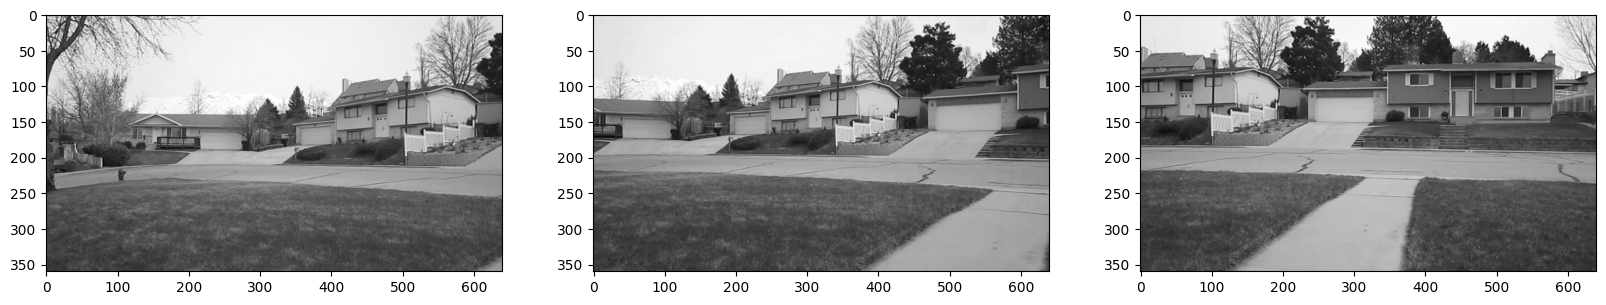

In [3]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(img1,'gray')
plt.subplot(1,3,2)
plt.imshow(img2,'gray')
plt.subplot(1,3,3)
plt.imshow(img3,'gray')
plt.show()

In [4]:
img1.shape,img2.shape,img3.shape #all are of same size

((360, 640), (360, 640), (360, 640))

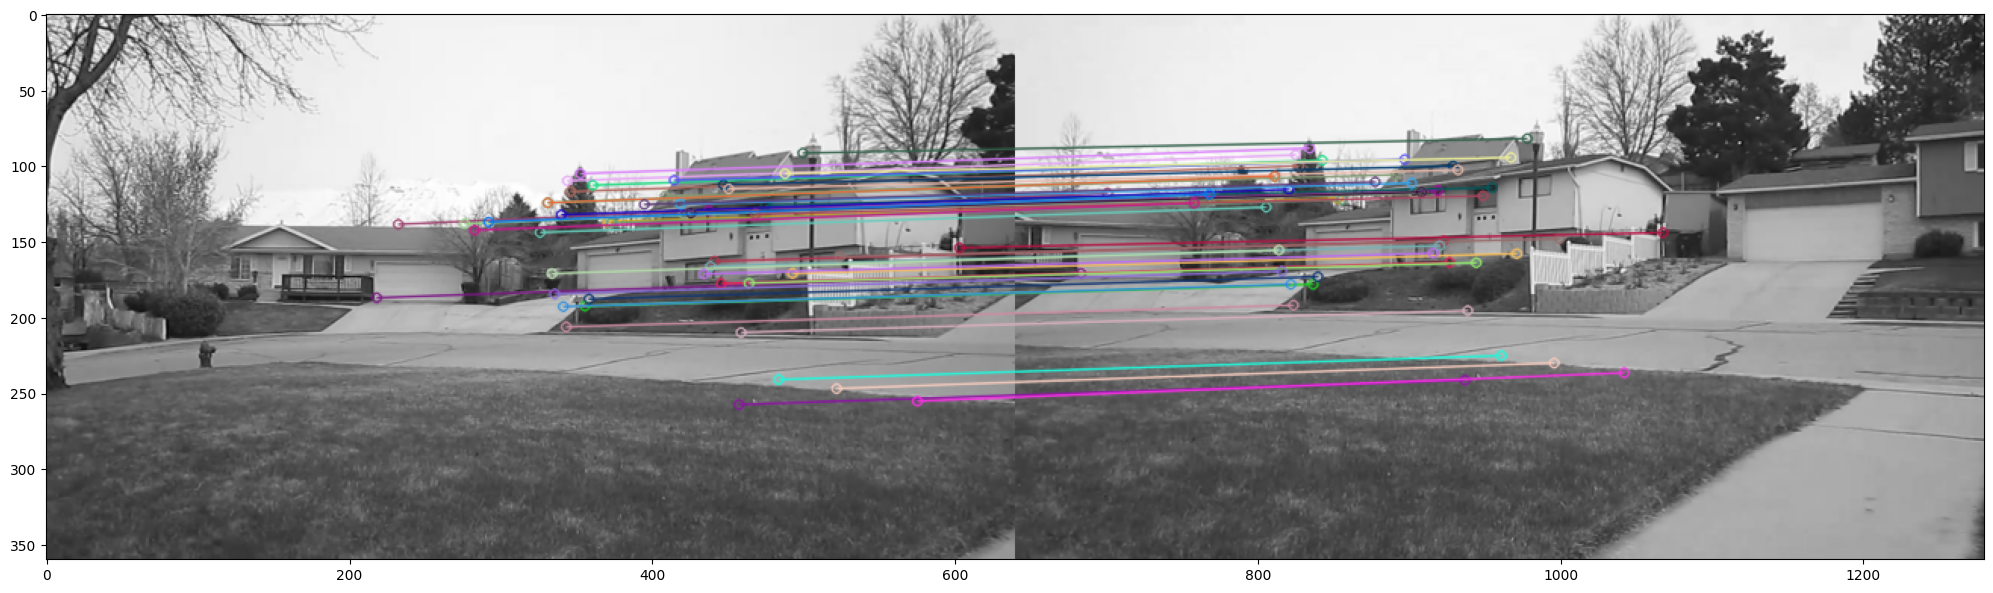

In [4]:
### this codes are taken directly from the gfg , working of the code can be explained 
sift = cv2.SIFT_create() #creating SIFT object
keypoints1, descriptors1 = sift.detectAndCompute(img1,None) #Finding matches in images
keypoints2, descriptors2 = sift.detectAndCompute(img2,None)
keypoints3, descriptors3 = sift.detectAndCompute(img3,None)

bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches12 = bf.match(descriptors1,descriptors2)
matches12 = sorted(matches12, key = lambda x:x.distance)
matched_img12 = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches12[:50], img2, flags=2) 
fig = plt.figure(figsize=(25, 25))#PLot to show matches
plt.imshow(matched_img12,cmap='gray')

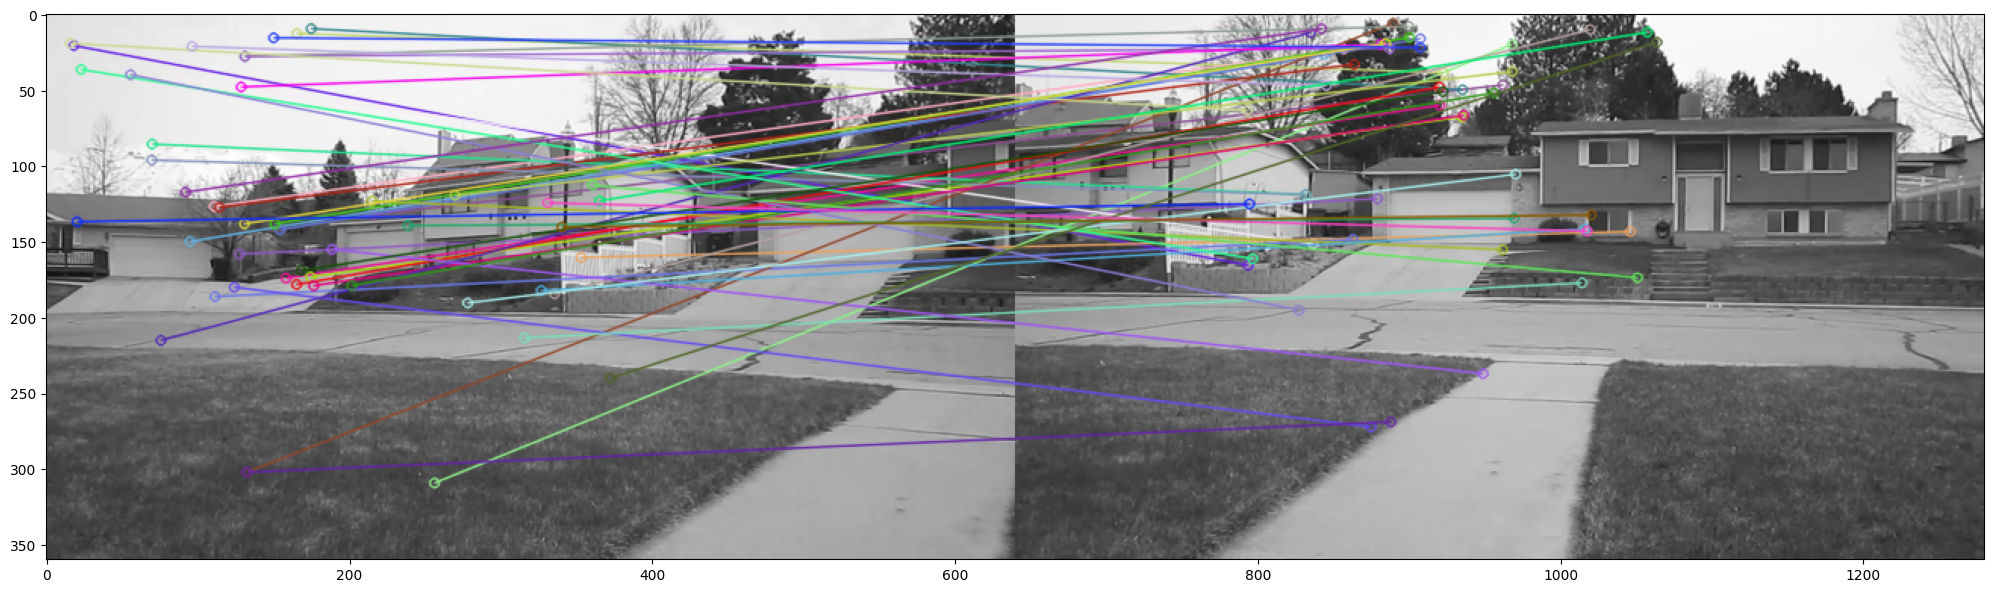

In [6]:
matches23=bf.match(descriptors3,descriptors2)
matches23 = sorted(matches23, key = lambda x:x.distance)
matched_img23 = cv2.drawMatches(img2, keypoints1, img3, keypoints3, matches23[:50], img2, flags=2)
fig = plt.figure(figsize=(25, 25))
plt.imshow(matched_img23,cmap='gray')

In [7]:
point_set1=[]  #empty list for the p1 
for match in matches12:
    point_set1.append(([keypoints1[match.queryIdx].pt],[keypoints2[match.trainIdx].pt])) # extracting the pixel location
                                                                                       # between image 1 and image 2
    
point_set2=[]  #empty list for the p2 (for 3 and 2 )
for match in matches23:
    point_set2.append(([keypoints3[match.queryIdx].pt],[keypoints2[match.trainIdx].pt])) # extracting the pixel location
                                                                                       # between image 2 and image 3
    

In [8]:
def homography(points,c_points):  # homography matrix as in Lab 2 
    n=len(points)                 # the equation is modified based on the requirements 
    Amat=np.zeros((2*n,9)) 
    
    for i in range(n):
        x,y=points[i][0][0],points[i][0][1] #cordinates of image 
        x_p,y_p=c_points[i][0][0],c_points[i][0][1]# cordinates of the corresponding image
        Amat[2*i]=[x,y,1,0,0,0,-x_p*x,-x_p*y,-x_p]
        Amat[2*i+1]=[0,0,0,x,y,1,-x*y_p,-y*y_p,-y_p]# A matrix caculation
    A_t=np.transpose(Amat)
    val=np.matmul(A_t,Amat)
    u, s, v= np.linalg.svd(val)# following constarined least square which is described in the last assignment
    H=np.reshape(v[-1],(3,3))  # svd calculation and last row reversal 
    return H

In [9]:
#implementing RANSAC for the choice of the best points from the set 
# iterations and epsilon are the parameters you can play with to max or min the set required 
# need to verify with the built in methods of skimage ransac 
def ransac(points1,epsilon,fraction,n_iter):
    flag=1
    ite=0
    while(flag):
        points=random.sample(points1,4) # Randomly taking 4 pair of points to build the equations
        p=[]
        c=[]
        for i in range(4):
            c.append(points[i][0])#points of image 1/3

        for i in range(4):
            p.append(points[i][1])# points of image 2

        H=homography(p,c)
        C=[] # cocnsensus set
        for pts in points1:
            vec=[pts[1][0][0],pts[1][0][1],1] #Converting to homogeneous coordinate
            dp_c=np.matmul(H,vec)
            dp_c/=dp_c[2]#Normalizing
            vec1=[pts[0][0][0],pts[0][0][1],1]
            sq_error=np.linalg.norm(dp_c-vec1) #Finding squarred error 
            if sq_error<epsilon: #checking if error is smaller than threshold value
                C.append(vec) 
                ite=ite+1
            if len(C)>fraction*len(points1) or ite>n_iter : #loop-breaking condition
                flag=0
    return H

In [10]:
def bilinear_interpolation(source , x , y ):  #from lab1
    '''
    input params : source =  source image 
                    x =  x coordinate 
                    y = y coordinate 
                    
        output : returns a target image
    '''
    
    xx = source.shape[0]   # shape of the input image 
    yy = source.shape[1]    
    
    x_dash = m.floor(x)    #  floor value of the coordinate (x ' and y' as mentioned in the class)  
    y_dash = m.floor(y)
    
    a = x - x_dash       # finding a and b i.e difference between actual and the floor value of the coordinate
    b = y - y_dash
    
    if x_dash >= 0 and y_dash>=0 and x_dash <= xx-2 and y_dash <= yy-2:  ##formula 
        target_img =(1-a)*(1-b)*source[x_dash,y_dash]+ (1-a)*b*source[x_dash,y_dash+1]+ a*(1-b)*source[x_dash+1,y_dash]+a*b*source[x_dash+1,y_dash+1]
        canvas = 1
    else:
        target_img = 0     # without using this condition , zeros wouldn't be created , it wud repeat the same values
        canvas = 0
    return target_img ,canvas 

In [11]:
H12=ransac(point_set1,10,0.8,10000) #ransac between img2 and img1 
H12

array([[-3.82621994e-03,  1.74928910e-04, -9.81289852e-01],
       [ 4.65424073e-04, -4.63436275e-03, -1.92368577e-01],
       [ 2.19564473e-06,  5.05396339e-07, -5.30958426e-03]])

In [12]:
H23=ransac(point_set2,10,0.8,10000) #ransac between image 3 and 2 
H23

array([[-3.71241031e-03, -1.80414277e-05,  9.72871721e-01],
       [-4.18266790e-04, -3.22929719e-03,  2.31282612e-01],
       [-2.37953930e-06, -1.64681633e-07, -2.14084598e-03]])

###### creating canvas

In [13]:
##canvas creating 
x1, y1 =np.shape(img1)
x2, y2 =np.shape(img2)
x3, y3 = np.shape(img3)

canvas_row=x1+x2+x3
canvas_column=y1+y2+y3

canvas=np.zeros((canvas_row,canvas_column))  #1080,1920

offset_row = np.ceil(canvas_row/3) #Offsetting so that image 2 can be stiched
offset_column = np.ceil(canvas_column/3)

for ii in range(0,canvas_column):
    for jj in range(0,canvas_row):
        i=ii-offset_row
        j=jj-offset_column
        vec=np.array([i,j,1])
        
        xs1,ys1,d1=np.matmul(H12,vec) #Target->Source mapping then normalizing to a homogeneous coordinate form
        if d1!=0:
            xs1=xs1/d1
            ys1=ys1/d1
        else:
            xs1=ys1=0
        
        xs2,ys2,d2=np.matmul(H23,vec) 
        if d2!=0:
            xs2=xs2/d2
            ys2=ys2/d2
        else:
            xs2=ys2=0
            
        
        #Extracting the interpolated intensity values
        
        val1,range1=bilinear_interpolation(img1,ys1,xs1)
        val2,range2=bilinear_interpolation(img2,j,i)
        val3,range3=bilinear_interpolation(img3,ys2,xs2)
        
        in_range=range1+range2+range3 #parameter to check if 2 or more images overlap or not
        
        val=0 #intensity values
        
        if range1>0:
            val=(val+val1) #image 1 is there
        
        if range2>0:
            val=(val+val2) #image 2 is there
            
        if range3>0:
            val=(val+val3) #image 3 is there
        
        if in_range>0:
            val=val/in_range # this is done so that brightness value of two images dont increase in the overlaped region
            
        canvas[jj,ii]=val

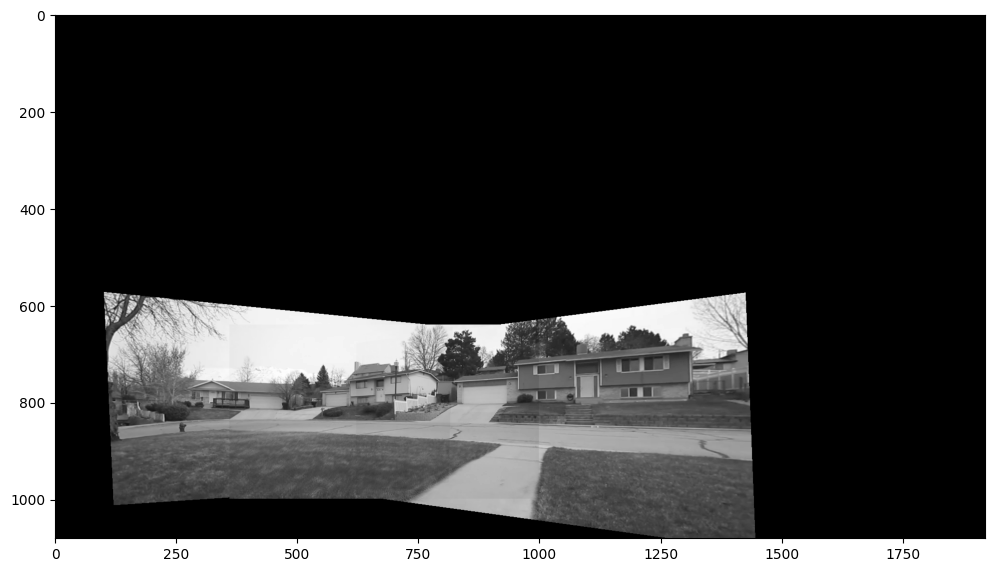

In [14]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(canvas[:,:],cmap='gray')

###### for own images 

In [15]:
img1 = imread('./i1.jpg' , as_gray = True)
img2 = imread('./i2.jpg' , as_gray = True )
img3 = imread('./i3.jpg' , as_gray = True)

In [16]:
i1 = img1[::5,::5]
i2 = img2[::5,::5]
i3 = img3[::5,::5]

In [17]:
i1 = (i1*255).astype('uint8')
i2 = (i2*255).astype('uint8')
i3 = (i3*255).astype('uint8')

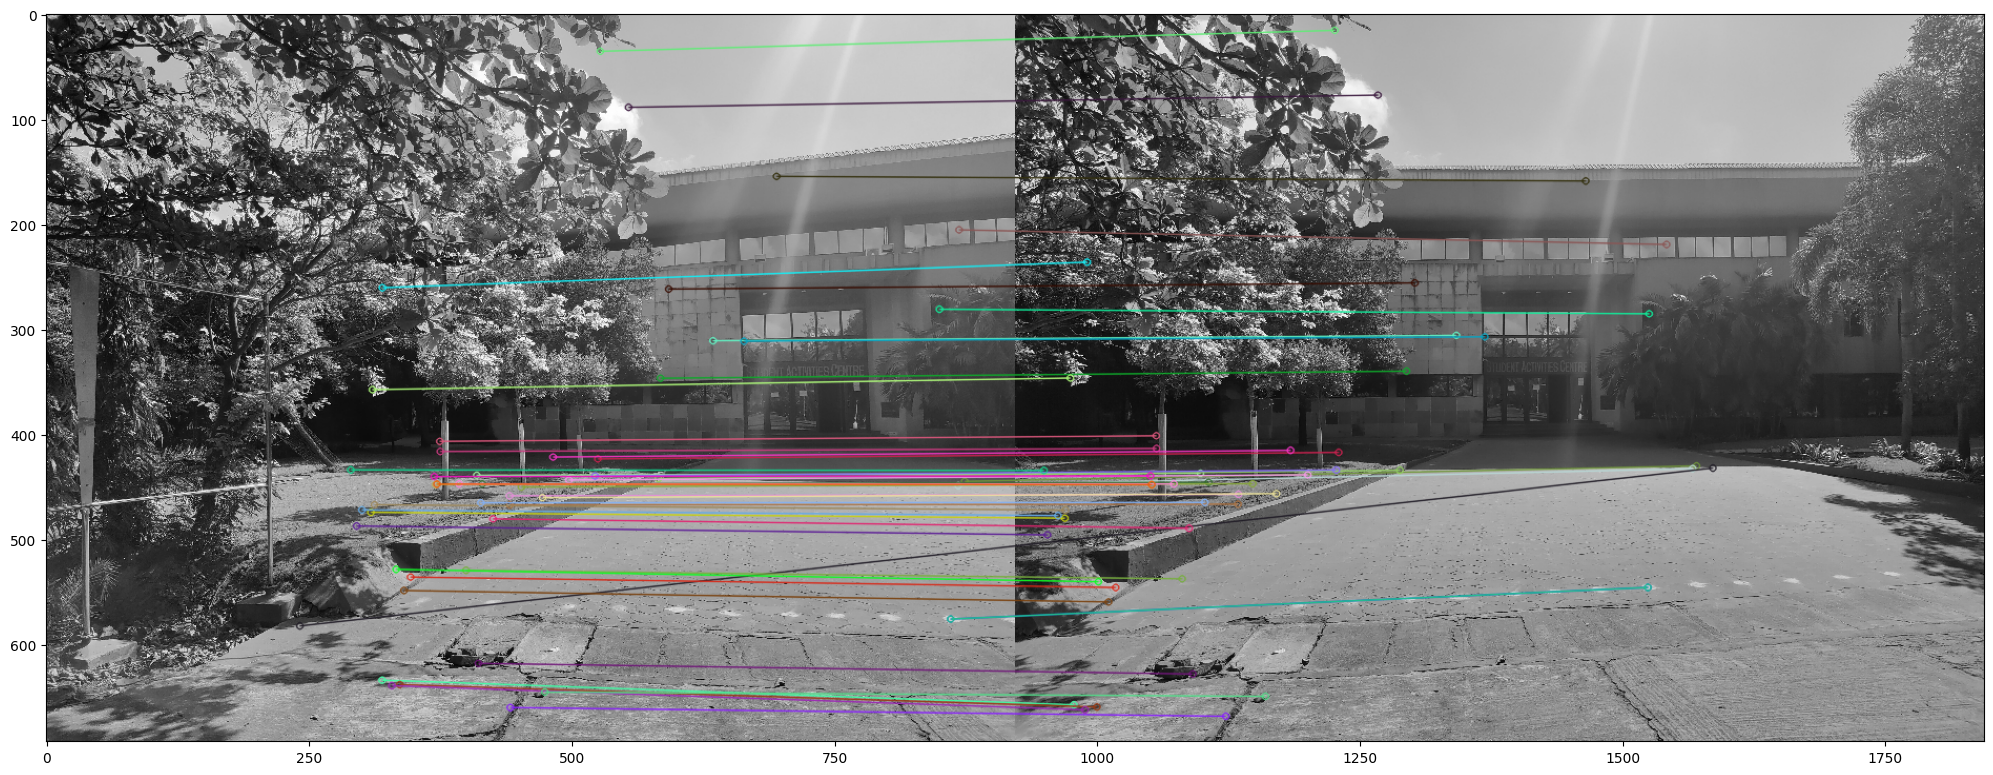

In [18]:
sift = cv2.SIFT_create() #creating SIFT object
keypoints11, descriptors11 = sift.detectAndCompute(i1,None) #Finding matches in images
keypoints22, descriptors22 = sift.detectAndCompute(i2,None)
keypoints33, descriptors33 = sift.detectAndCompute(i3,None)

bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches12 = bf.match(descriptors11,descriptors22)
matches12 = sorted(matches12, key = lambda x:x.distance)
matched_img12 = cv2.drawMatches(i1, keypoints11, i2, keypoints22, matches12[:50], i2, flags=2) 
fig = plt.figure(figsize=(25, 25))#PLot to show matches
plt.imshow(matched_img12,cmap='gray')

In [19]:
matches23=bf.match(descriptors33,descriptors22)
matches23 = sorted(matches23, key = lambda x:x.distance)
# matched_img23 = cv2.drawMatches(i2, keypoints1, i3, keypoints3, matches23[:50], i2, flags=2)
# fig = plt.figure(figsize=(25, 25))
# plt.imshow(matched_img23,cmap='gray')

In [20]:
point_set1=[]
for match in matches12:
    point_set1.append(([keypoints11[match.queryIdx].pt],[keypoints22[match.trainIdx].pt])) # extracting the pixel location
                                                                                       # between image 1 and image 2
    
point_set2=[]
for match in matches23:
    point_set2.append(([keypoints33[match.queryIdx].pt],[keypoints22[match.trainIdx].pt])) # extracting the pixel location
                                                                                       # between image 2 and image 3
    

In [21]:
H12=ransac(point_set1,10,0.8,1000)
H12

array([[ 2.63184010e-03, -1.20127996e-04,  9.74550242e-01],
       [-4.00296358e-04,  2.94282024e-03,  2.24104758e-01],
       [-7.98901736e-07, -3.84876365e-07,  3.62250730e-03]])

In [22]:
H23=ransac(point_set2,10,0.8,1000)
H23

array([[ 8.49401069e-03, -1.75959825e-03, -7.54459047e-01],
       [ 7.02369219e-03, -1.43911348e-03, -6.56249139e-01],
       [ 1.49231871e-05, -2.49837894e-06, -1.40225930e-03]])

In [23]:
x1, y1 =np.shape(i1)
x2, y2 =np.shape(i2)
x3, y3 = np.shape(i3)

canvas_row=x1+x2+x3
canvas_column=y1+y2+y3

canvas=np.zeros((canvas_row,canvas_column))  #1080,1920

offset_row = np.ceil(canvas_row/3) #Offsetting so that image 2 can be stiched
offset_column = np.ceil(canvas_column/3)

for ii in range(0,canvas_column):
    for jj in range(0,canvas_row):
        i=ii-offset_row
        j=jj-offset_column
        vec=np.array([i,j,1])
        
        xs1,ys1,d1=np.matmul(H12,vec) #Target->Source mapping then normalizing to a homogeneous coordinate form
        if d1!=0:
            xs1=xs1/d1
            ys1=ys1/d1
        else:
            xs1=ys1=0
        
        xs2,ys2,d2=np.matmul(H23,vec) 
        if d2!=0:
            xs2=xs2/d2
            ys2=ys2/d2
        else:
            xs2=ys2=0
            
        
        #Extracting the interpolated intensity values
        
        val1,range1=bilinear_interpolation(img1,ys1,xs1)
        val2,range2=bilinear_interpolation(img2,j,i)
        val3,range3=bilinear_interpolation(img3,ys2,xs2)
        
        in_range=range1+range2+range3 #parameter to check if 2 or more images overlap or not
        
        val=0 #intensity values
        
        if range1>0:
            val=(val+val1) #image 1 is there
        
        if range2>0:
            val=(val+val2) #image 2 is there
            
        if range3>0:
            val=(val+val3) #image 3 is there
        
        if in_range>0:
            val=val/in_range # this is done so that brightness value of two images dont increase in the overlaped region
            
        canvas[jj,ii]=val

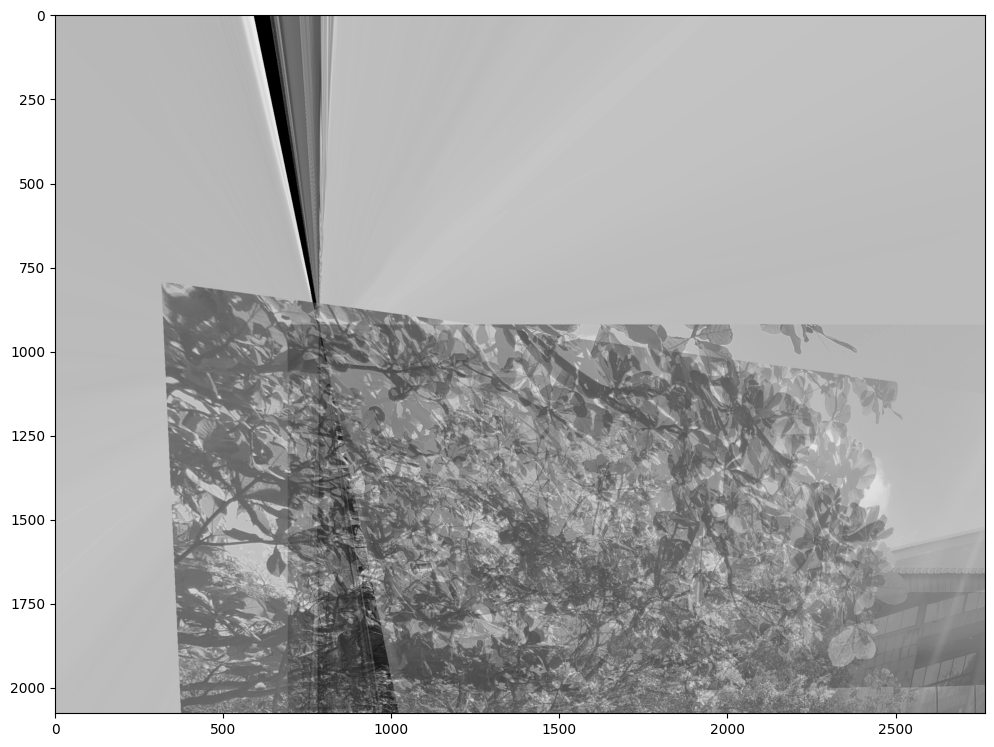

In [24]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(canvas,cmap='gray')

##### conclusions

* homography is established between 2 and 1 and then in between 3 and 2 (order in which we give is important)
* since ransac is a random set creation , it might not always result in the best set, so you need to keep re-running it 
* sift does the feature extractions but there are more robust methods like SURF,AKAZE,KAZE etc., to do the same 